In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob

# Classify using reservoir causality data

In [2]:
# load computed causality matrices
con_files = [f for f in glob.glob("data/sub-CON*.npy")]
pat_files = [f for f in glob.glob("data/sub-PAT*.npy")]

# filter out excluded subjects
excluded = ["PAT08", "CON03", "PAT03", "PAT11"]
con_files = [f for f in con_files if f[9:14] not in excluded]
pat_files = [f for f in pat_files if f[9:14] not in excluded]

# transform for LDA
con_causalities = np.array([np.load(f) for f in con_files])
pat_causalities = np.array([np.load(f) for f in pat_files])
con_flattened = con_causalities.reshape((con_causalities.shape[0], -1))
pat_flattened = pat_causalities.reshape((pat_causalities.shape[0], -1))

In [3]:
# causality = np.load("data/sub-PAT14_ses-preop_task-rest_space-MNI152NLin2009cAsym_atlas-Gordon_desc-timeseries_bold_causality_matrix.npy")
# plt.figure(figsize=(10,10))
# plt.imshow(causality, cmap='hot')

In [4]:
# perform LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# use SVM
from sklearn.svm import SVC

lda = LinearDiscriminantAnalysis()
svc = SVC(kernel='rbf')


_xs = np.concatenate((con_flattened, pat_flattened))
_ys = np.concatenate((np.zeros(con_flattened.shape[0]), np.ones(pat_flattened.shape[0])))
# replace nans in _xs with 0
_xs[np.isnan(_xs)] = 0

# 2-fold cross-validation (randomized)
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=4, test_size=0.5, random_state=0)

lda_coefs = []
for train_index, test_index in ss.split(_xs, _ys):
    X_train, X_test = _xs[train_index], _xs[test_index]
    y_train, y_test = _ys[train_index], _ys[test_index]
    lda.fit(X_train, y_train)
    svc.fit(X_train, y_train)

    print("LDA score:", lda.score(X_test, y_test), "  SVC score: ", svc.score(X_test, y_test))

    # y_pred = lda.predict(X_test)
    # y_pred = svc.predict(X_test)
    # print(y_pred) 
    # print(y_test)

    # coefs = lda.coef_.reshape((con_causalities.shape[1], con_causalities.shape[2]))
    # plt.figure(figsize=(10,10))
    # plt.imshow(coefs, cmap='hot')
    # lda_coefs.append(lda.coef_)

# # correlation between coefficients
# lda_robustness = np.corrcoef(lda_coefs[0], lda_coefs[1])[0, 1]
# print("\nLDA robustness: ", lda_robustness)

LDA score: 0.4   SVC score:  0.5
LDA score: 0.3   SVC score:  0.3
LDA score: 0.4   SVC score:  0.5
LDA score: 0.4   SVC score:  0.4


In [5]:
# coefs = lda.coef_.reshape((con_causalities.shape[1], con_causalities.shape[2]))
# plt.figure(figsize=(10,10))
# plt.imshow(coefs, cmap='hot')

# Classify using region correlations

In [6]:
con_fmri_files = [f[:-21] + ".tsv" for f in con_files]
pat_fmri_files = [f[:-21] + ".tsv" for f in pat_files]

In [70]:
import warnings
warnings.filterwarnings("ignore")

con_corr_matrices = []
for filename in con_fmri_files:
    df = pd.read_csv(filename, header=None)
    data = np.array(df)
    correlation_matrix = np.corrcoef(data.T)
    con_corr_matrices.append(correlation_matrix)
pat_corr_matrices = []
for filename in pat_fmri_files:
    df = pd.read_csv(filename, header=None)
    data = np.array(df)
    correlation_matrix = np.corrcoef(data.T)
    pat_corr_matrices.append(correlation_matrix)

# flatten for LDA
con_correlations = np.array(con_corr_matrices)
pat_correlations = np.array(pat_corr_matrices)
con_flattened = con_correlations.reshape((con_correlations.shape[0], -1))
pat_flattened = pat_correlations.reshape((pat_correlations.shape[0], -1))

In [8]:
# perform LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# use SVM
from sklearn.svm import SVC

lda = LinearDiscriminantAnalysis()
svc = SVC(kernel='rbf')

_xs = np.concatenate((con_flattened, pat_flattened))
_ys = np.concatenate((np.zeros(con_flattened.shape[0]), np.ones(pat_flattened.shape[0])))
# replace nans in _xs with 0
_xs[np.isnan(_xs)] = 0

# 2-fold cross-validation (randomized)
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=4, test_size=0.5, random_state=4)

lda_coefs = []
for train_index, test_index in ss.split(_xs, _ys):
    X_train, X_test = _xs[train_index], _xs[test_index]
    y_train, y_test = _ys[train_index], _ys[test_index]

    lda.fit(X_train, y_train)
    svc.fit(X_train, y_train)

    print("LDA score:", lda.score(X_test, y_test), "  SVC score: ", svc.score(X_test, y_test))

    # print(y_pred) 
    # print(y_test)

    # coefs = lda.coef_.reshape((con_causalities.shape[1], con_causalities.shape[2]))
    # plt.figure(figsize=(10,10))
    # plt.imshow(coefs, cmap='hot')
    lda_coefs.append(lda.coef_)

# # correlation between coefficients
# lda_robustness = np.corrcoef(lda_coefs[0], lda_coefs[1])[0, 1]
# print("\nLDA robustness: ", lda_robustness)

LDA score: 0.1   SVC score:  0.4
LDA score: 0.2   SVC score:  0.3
LDA score: 0.6   SVC score:  0.5
LDA score: 0.4   SVC score:  0.5


# Visualize causalities

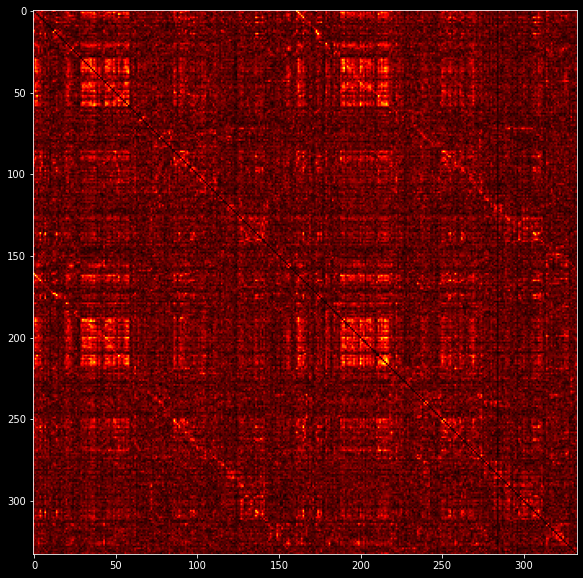

In [57]:
avg_con_causality = con_causalities.mean(axis=0)
avg_con_causality[np.isnan(avg_con_causality)] = 0

plt.figure(figsize=(10,10))
plt.imshow(avg_con_causality, cmap='hot')

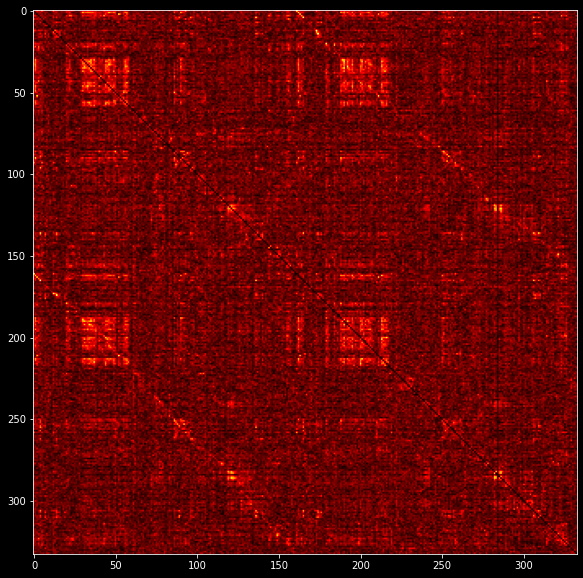

In [56]:
avg_pat_causality = pat_causalities.mean(axis=0)
avg_pat_causality[np.isnan(avg_pat_causality)] = 0

plt.figure(figsize=(10,10))
plt.imshow(avg_pat_causality, cmap='hot')

# Get averages of networks

In [31]:
parcels_filename = "data/Parcels.xlsx"
parcels_df = pd.read_excel(parcels_filename)

/home/filip/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [32]:
# replace nans with 0
con_causalities[np.isnan(con_causalities)] = 0
pat_causalities[np.isnan(pat_causalities)] = 0

# replace negative values with 0
con_causalities[con_causalities < 0] = 0
pat_causalities[pat_causalities < 0] = 0

In [33]:
# get all the unique communities
communities = parcels_df["Community"].unique()

# for each community get the parcels
community_parcels = {}
for community in communities:
    parcels = parcels_df[parcels_df["Community"] == community]["ParcelID"].values
    community_parcels[community] = parcels - 1  # index from 0!

In [66]:
# for each community get the average causality
community_con_causality_dict = {}
community_pat_causality_dict = {}
for community, parcels in community_parcels.items():
    community_con_causalities = []
    community_pat_causalities = []
    sum_of_pat_caustalities = np.zeros(pat_causalities.shape[0])
    for i in parcels:
        for j in parcels:
            if i == j:
                continue
            community_con_causalities.append(con_causalities[:, i, j])
            community_pat_causalities.append(pat_causalities[:, i, j])
            # community_con_causalities.append(con_correlations[:, i, j])
            # community_pat_causalities.append(pat_correlations[:, i, j])
    community_con_causality_dict[community] = np.array(community_con_causalities).mean(axis=0)
    community_pat_causality_dict[community] = np.array(community_pat_causalities).mean(axis=0)


In [67]:
from scipy.stats import ttest_ind

for community in communities:
    con_values = community_con_causality_dict[community]
    pat_values = community_pat_causality_dict[community]

    total_community_avg = np.mean(np.concatenate((con_values, pat_values)))
    total_community_std = np.std(np.concatenate((con_values, pat_values)))

    # perform a t test
    t, p = ttest_ind(con_values, pat_values)
    print(f"Community: {community:25}  p: {p:6.3f}    avg: {total_community_avg:6.3f}   std: {total_community_std:6.3f}")
    # print(con_values, pat_values)

Community: Default                    p:  0.827    avg:  0.149   std:  0.030
Community: SMhand                     p:  0.396    avg:  0.251   std:  0.091
Community: SMmouth                    p:  0.326    avg:  0.315   std:  0.145
Community: Visual                     p:  0.272    avg:  0.174   std:  0.059
Community: FrontoParietal             p:  0.340    avg:  0.123   std:  0.022
Community: Auditory                   p:  0.986    avg:  0.125   std:  0.034
Community: None                       p:  0.872    avg:  0.123   std:  0.034
Community: CinguloParietal            p:  0.769    avg:  0.219   std:  0.074
Community: RetrosplenialTemporal      p:  0.471    avg:  0.171   std:  0.058
Community: CinguloOperc               p:  0.249    avg:  0.133   std:  0.028
Community: VentralAttn                p:  0.380    avg:  0.113   std:  0.022
Community: Salience                   p:  0.747    avg:  0.118   std:  0.047
Community: DorsalAttn                 p:  0.386    avg:  0.145   std:  0.027

In [68]:

# for each community get the average causality
community_con_causality_dict = {}
community_pat_causality_dict = {}
for community, parcels in community_parcels.items():
    community_con_causalities = []
    community_pat_causalities = []
    sum_of_pat_caustalities = np.zeros(pat_causalities.shape[0])
    for i in parcels:
        for j in parcels:
            if i == j:
                continue
            # community_con_causalities.append(con_causalities[:, i, j])
            # community_pat_causalities.append(pat_causalities[:, i, j])
            community_con_causalities.append(con_correlations[:, i, j])
            community_pat_causalities.append(pat_correlations[:, i, j])
    community_con_causality_dict[community] = np.array(community_con_causalities).mean(axis=0)
    community_pat_causality_dict[community] = np.array(community_pat_causalities).mean(axis=0)


In [69]:
from scipy.stats import ttest_ind

for community in communities:
    con_values = community_con_causality_dict[community]
    pat_values = community_pat_causality_dict[community]

    total_community_avg = np.mean(np.concatenate((con_values, pat_values)))
    total_community_std = np.std(np.concatenate((con_values, pat_values)))

    # perform a t test
    t, p = ttest_ind(con_values, pat_values)
    print(f"Community: {community:25}  p: {p:6.3f}    avg: {total_community_avg:6.3f}   std: {total_community_std:6.3f}")
    # print(con_values, pat_values)

Community: Default                    p:  0.763    avg:  0.167   std:  0.056
Community: SMhand                     p:  0.563    avg:  0.343   std:  0.115
Community: SMmouth                    p:  0.225    avg:  0.411   std:  0.154
Community: Visual                     p:  0.392    avg:  0.215   std:  0.077
Community: FrontoParietal             p:  0.384    avg:  0.114   std:  0.041
Community: Auditory                   p:  0.819    avg:  0.146   std:  0.077
Community: None                       p:    nan    avg:    nan   std:    nan
Community: CinguloParietal            p:  0.953    avg:  0.288   std:  0.119
Community: RetrosplenialTemporal      p:  0.444    avg:  0.217   std:  0.093
Community: CinguloOperc               p:  0.173    avg:  0.170   std:  0.052
Community: VentralAttn                p:  0.819    avg:  0.094   std:  0.046
Community: Salience                   p:  0.174    avg:  0.166   std:  0.106
Community: DorsalAttn                 p:  0.741    avg:  0.178   std:  0.045